        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


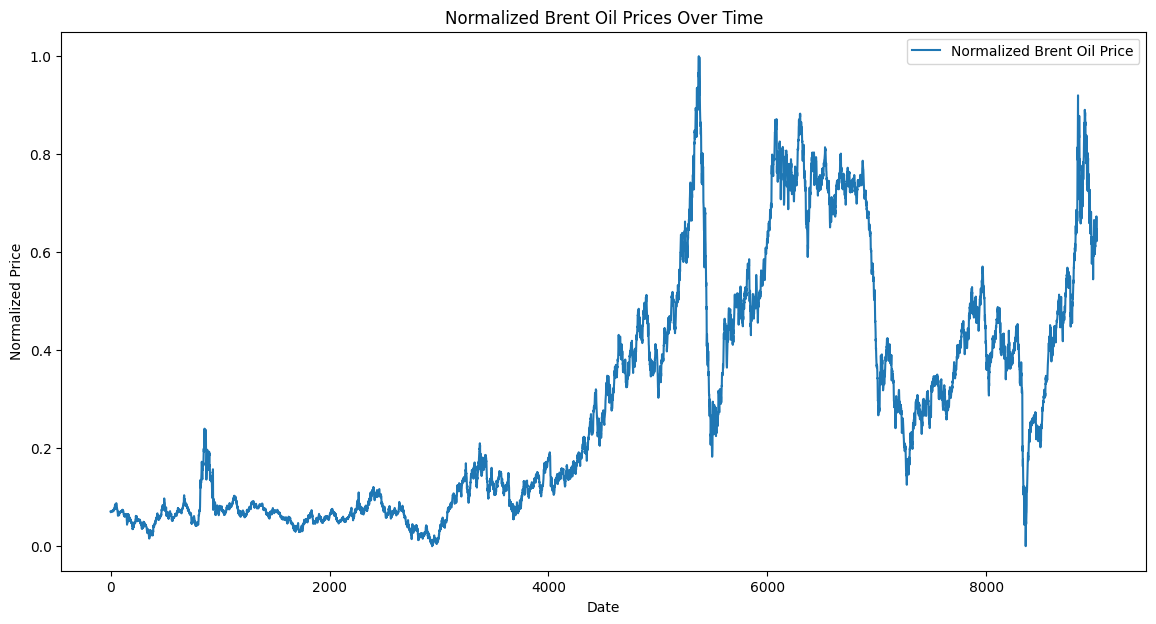

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout



df = pd.read_parquet('brent_oil_price.parquet')


# Display the first few rows of the dataset
print(df.head())

# Handle missing values (if any)
df = df.dropna()

# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Normalized_Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Plot the normalized prices
plt.figure(figsize=(14, 7))
plt.plot(df['Normalized_Price'], label='Normalized Brent Oil Price')
plt.title('Normalized Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

# Prepare the data and Split

In [5]:
# Convert the dataframe to a numpy array
data = df['Normalized_Price'].values

# Define a function to create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Create sequences and labels
seq_length = 60
X, y = create_sequences(data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input to be 3D [samples, timesteps, features] as required by LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Train the model

Epoch 1/20
224/224 [==============================] - 18s 62ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 2/20
224/224 [==============================] - 13s 57ms/step - loss: 0.0014 - val_loss: 9.1764e-04
Epoch 3/20
224/224 [==============================] - 13s 58ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/20
224/224 [==============================] - 14s 62ms/step - loss: 0.0011 - val_loss: 5.7265e-04
Epoch 5/20
224/224 [==============================] - 13s 58ms/step - loss: 9.2779e-04 - val_loss: 5.2572e-04
Epoch 6/20
224/224 [==============================] - 13s 58ms/step - loss: 9.0814e-04 - val_loss: 5.7227e-04
Epoch 7/20
224/224 [==============================] - 13s 59ms/step - loss: 8.7495e-04 - val_loss: 7.0862e-04
Epoch 8/20
224/224 [==============================] - 13s 58ms/step - loss: 8.4062e-04 - val_loss: 4.9499e-04
Epoch 9/20
224/224 [==============================] - 13s 58ms/step - loss: 7.6866e-04 - val_loss: 5.4079e-04
Epoch 10/20
224/224 [=============

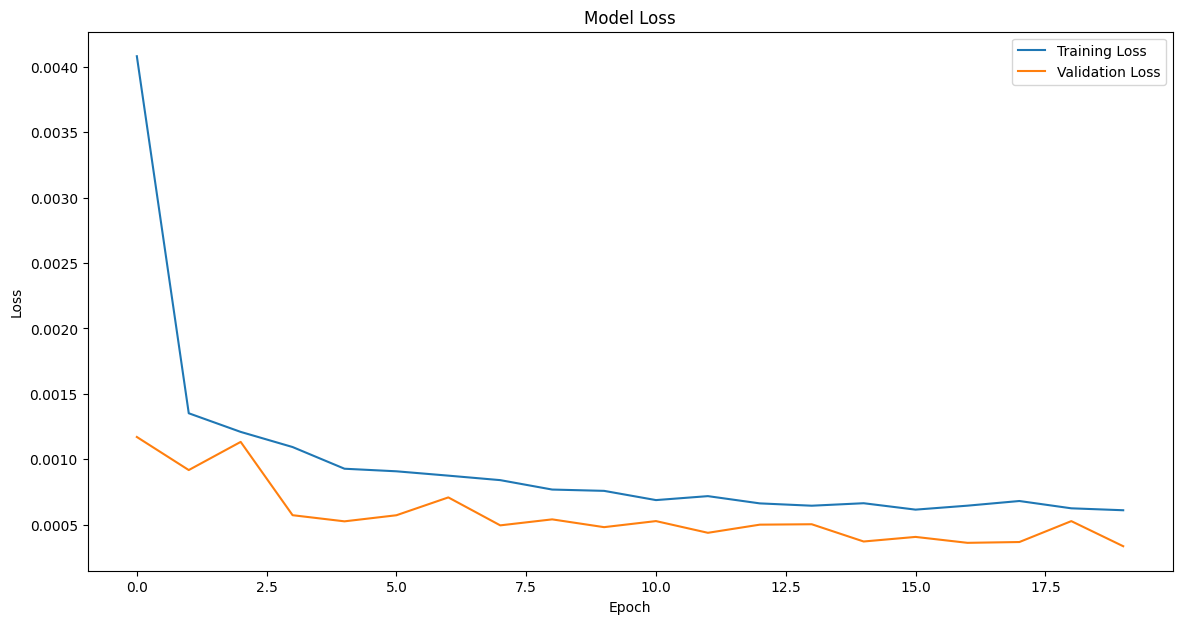

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions

56/56 [==============================] - 2s 15ms/step


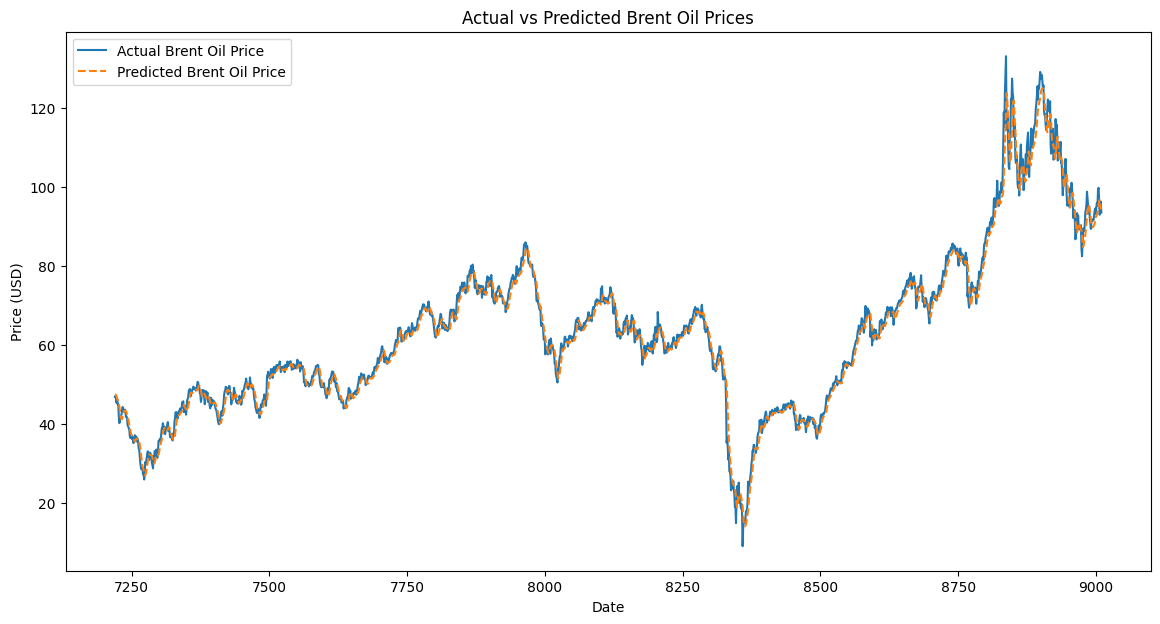

In [8]:
predicted_prices = model.predict(X_test)

# Invert the normalization for predicted prices
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame to store actual and predicted prices
predictions_df = pd.DataFrame({
    'Date': df.index[-len(predicted_prices):],
    'Actual_Price': actual_prices.flatten(),
    'Predicted_Price': predicted_prices.flatten()
})

# Plot the actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(predictions_df['Date'], predictions_df['Actual_Price'], label='Actual Brent Oil Price')
plt.plot(predictions_df['Date'], predictions_df['Predicted_Price'], label='Predicted Brent Oil Price', linestyle='--')
plt.title('Actual vs Predicted Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()